<a href="https://colab.research.google.com/github/ryogrid/ryogridJupyterNotebooks/blob/master/cartpole_dopamine_official_examaple200118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Dopamine: How to train an agent on Cartpole

This colab demonstrates how to train the DQN and C51 on Cartpole, based on the default configurations provided.

The hyperparameters chosen are by no mean optimal. The purpose of this colab is to illustrate how to train two
agents on a non-Atari gym environment: cartpole.

We also include default configurations for Acrobot in our repository: https://github.com/google/dopamine

Run all the cells below in order.

In [0]:
# @title Install necessary packages.
!pip install --upgrade --no-cache-dir dopamine-rl
!pip install gin-config

     |████████████████████████████████| 92kB 5.1MB/s 
  Found existing installation: dopamine-rl 1.0.5
    Uninstalling dopamine-rl-1.0.5:
      Successfully uninstalled dopamine-rl-1.0.5


In [0]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

BASE_PATH = '/tmp/colab_dopamine_run'  # @param

## Train DQN

In [0]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
DQNAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
DQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
DQNAgent.network = @gym_lib.CartpoleDQNNetwork
DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 500
DQNAgent.update_period = 4
DQNAgent.target_update_period = 100
DQNAgent.epsilon_fn = @dqn_agent.identity_epsilon
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 200  # Default max episode length.

WrappedReplayBuffer.replay_capacity = 50000
WrappedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

In [0]:
# @title Train DQN on Cartpole
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

INFO:tensorflow:Creating TrainRunner ...
INFO:tensorflow:Creating DQNAgent agent with the following parameters:
INFO:tensorflow:	 gamma: 0.990000
INFO:tensorflow:	 update_horizon: 1.000000
INFO:tensorflow:	 min_replay_history: 500
INFO:tensorflow:	 update_period: 4
INFO:tensorflow:	 target_update_period: 100
INFO:tensorflow:	 epsilon_train: 0.010000
INFO:tensorflow:	 epsilon_eval: 0.001000
INFO:tensorflow:	 epsilon_decay_period: 250000
INFO:tensorflow:	 tf_device: /gpu:0
INFO:tensorflow:	 use_staging: True
INFO:tensorflow:	 optimizer: <tensorflow.python.training.adam.AdamOptimizer object at 0x7f9165288f98>
INFO:tensorflow:	 max_tf_checkpoints_to_keep: 4
INFO:tensorflow:Creating a OutOfGraphReplayBuffer replay memory with the following parameters:
INFO:tensorflow:	 observation_shape: (4, 1)
INFO:tensorflow:	 observation_dtype: <class 'numpy.float64'>
INFO:tensorflow:	 terminal_dtype: <class 'numpy.uint8'>
INFO:tensorflow:	 stack_size: 1
INFO:tensorflow:	 replay_capacity: 50000
INFO:tens

# Train C51

In [0]:
# @title Load the configuration for C51.

C51_PATH = os.path.join(BASE_PATH, 'c51')
# Modified from dopamine/agents/rainbow/config/c51_cartpole.gin
c51_config = """
# Hyperparameters for a simple C51-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.agents.dqn.dqn_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
RainbowAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
RainbowAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
RainbowAgent.network = @gym_lib.CartpoleRainbowNetwork
RainbowAgent.num_atoms = 51
RainbowAgent.vmax = 10.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 1
RainbowAgent.min_replay_history = 500
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 100
RainbowAgent.epsilon_fn = @dqn_agent.identity_epsilon
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'rainbow'
Runner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 200  # Default max episode length.

WrappedPrioritizedReplayBuffer.replay_capacity = 50000
WrappedPrioritizedReplayBuffer.batch_size = 128
"""
gin.parse_config(c51_config, skip_unknown=False)

In [0]:
# @title Train C51 on Cartpole
c51_runner = run_experiment.create_runner(C51_PATH, schedule='continuous_train')
print('Will train agent, please be patient, may be a while...')
c51_runner.run_experiment()
print('Done training!')

INFO:tensorflow:Creating TrainRunner ...
INFO:tensorflow:Creating RainbowAgent agent with the following parameters:
INFO:tensorflow:	 gamma: 0.990000
INFO:tensorflow:	 update_horizon: 1.000000
INFO:tensorflow:	 min_replay_history: 500
INFO:tensorflow:	 update_period: 4
INFO:tensorflow:	 target_update_period: 100
INFO:tensorflow:	 epsilon_train: 0.010000
INFO:tensorflow:	 epsilon_eval: 0.001000
INFO:tensorflow:	 epsilon_decay_period: 250000
INFO:tensorflow:	 tf_device: /gpu:0
INFO:tensorflow:	 use_staging: True
INFO:tensorflow:	 optimizer: <tensorflow.python.training.adam.AdamOptimizer object at 0x7f915d880dd8>
INFO:tensorflow:	 max_tf_checkpoints_to_keep: 4
INFO:tensorflow:Creating a OutOfGraphPrioritizedReplayBuffer replay memory with the following parameters:
INFO:tensorflow:	 observation_shape: (4, 1)
INFO:tensorflow:	 observation_dtype: <class 'numpy.float64'>
INFO:tensorflow:	 terminal_dtype: <class 'numpy.uint8'>
INFO:tensorflow:	 stack_size: 1
INFO:tensorflow:	 replay_capacity: 

# Plot the results

In [0]:
# @title Load the training logs.
data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                   summary_keys=['train_episode_returns'])
data['agent'] = 'DQN'
data['run'] = 1
c51_data = colab_utils.read_experiment(C51_PATH, verbose=True,
                                       summary_keys=['train_episode_returns'])
c51_data['agent'] = 'C51'
c51_data['run'] = 1
data = data.merge(c51_data, how='outer')

Reading statistics from: /tmp/colab_dopamine_run/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/c51//logs/log_49


/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


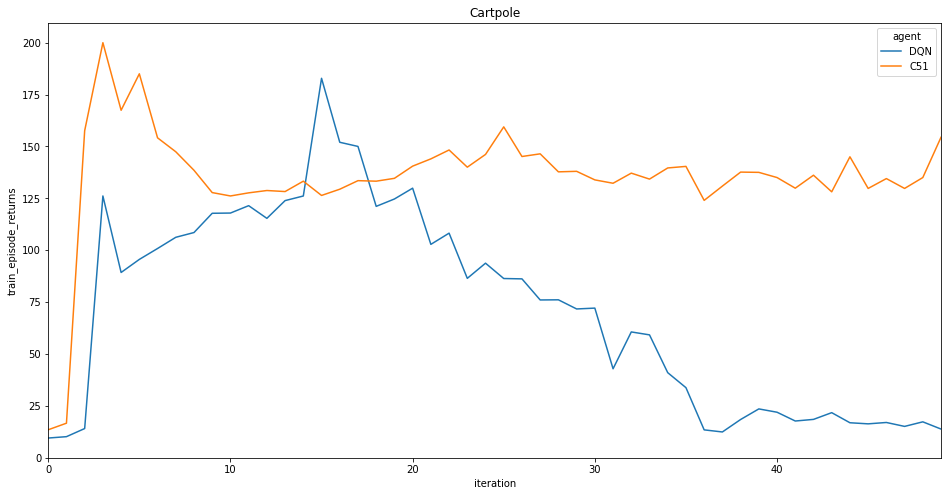

In [0]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=data, time='iteration', unit='run',
           condition='agent', value='train_episode_returns', ax=ax)
plt.title('Cartpole')
plt.show()